## Integrative Analysis of the Cervicovaginal Microbiome and Systemic Inflammation in HPV Persistence among Nigerian Women

### By Tiffany Tang 

### Introduction

Cervical cancer is one of the most preventable cancers, yet it remains a major cause of death among women in many low- and middle-income countries, particularly in sub-Saharan Africa. The leading cause of cervical cancer is persistent infection with high-risk types of human papillomavirus (hrHPV), especially types 16 and 18. While most HPV infections resolve naturally, a subset of women experience persistent infections that can eventually lead to cancer. The biological factors that determine whether an infection clears or persists are not yet fully understood.

Research suggests that two biological systems may play a critical role in shaping these outcomes: the cervicovaginal microbiome, the community of bacteria living in the vagina and cervix, and the immune system, particularly inflammation as measured by molecules called cytokines. A healthy vaginal microbiome is typically dominated by beneficial Lactobacillus species, which help maintain an acidic environment and protect against infections. When this balance is disrupted, bacterial vaginosis (BV) can occur, resulting in a more diverse microbial community often dominated by anaerobic bacteria. This shift has been associated with increased risk of HPV persistence and progression to cervical disease. In parallel, the immune system, particularly cytokines, plays a key role in controlling infection and may also be influenced by microbial imbalances.

In this project, I examine how BV status is associated with systemic immune signaling, as measured by blood-based cytokine profiles, in a Nigerian cohort. Nigeria carries one of the highest burdens of cervical cancer globally, yet remains significantly underrepresented in biomedical research. By exploring how BV may alter immune function through changes in cytokine expression, this work aims to reveal potential biological pathways that contribute to HPV persistence or clearance, ultimately informing prevention and early detection strategies tailored to underserved populations.

This study builds on a growing body of research highlighting the interconnected roles of the vaginal microbiome and immune system in HPV pathogenesis. Prior work by Usyk et al. (2022) showed that women with non-Lactobacillus-dominated microbiomes, particularly those enriched in Gardnerella or Atopobium, were more likely to develop persistent HPV infections, a finding extended to a Nigerian cohort by Musa et al. (2023), who linked high-diversity microbiomes with hrHPV infection and cervical precancer. On the immune side, studies by Usyk et al. (2024) and Li et al. (2019) found that specific blood cytokines are predictive of HPV persistence, while Zhou et al. (2021) and Ntuli et al. (2022) proposed mechanisms by which microbial dysbiosis drives chronic inflammation and immune dysregulation that may promote viral persistence. The HPV outcome data in this project derive from a longitudinal study by Mbulaiteye et al. (2013), which classified infections based on serial PCR testing. While previous research has explored these domains separately, few studies have jointly examined BV status and systemic cytokine profiles, particularly within African populations, where such insights are needed.

My project addresses this gap by integrating microbiome composition, systemic immune markers, and clinical metadata using machine learning tools to build predictive models of HPV persistence among Nigerian women. This comprehensive approach has the potential to uncover novel biomarkers of cervical cancer risk, improve early triage methods, and inform prevention strategies tailored to populations that have historically been overlooked in global health research.

We hypothesize that bacterial vaginosis (BV) status is associated with systemic immune signaling, and that combined patterns of vaginal microbiome composition and circulating cytokines can predict BV status and potentially inform risk of persistent HPV infection.

### Materials and Methods

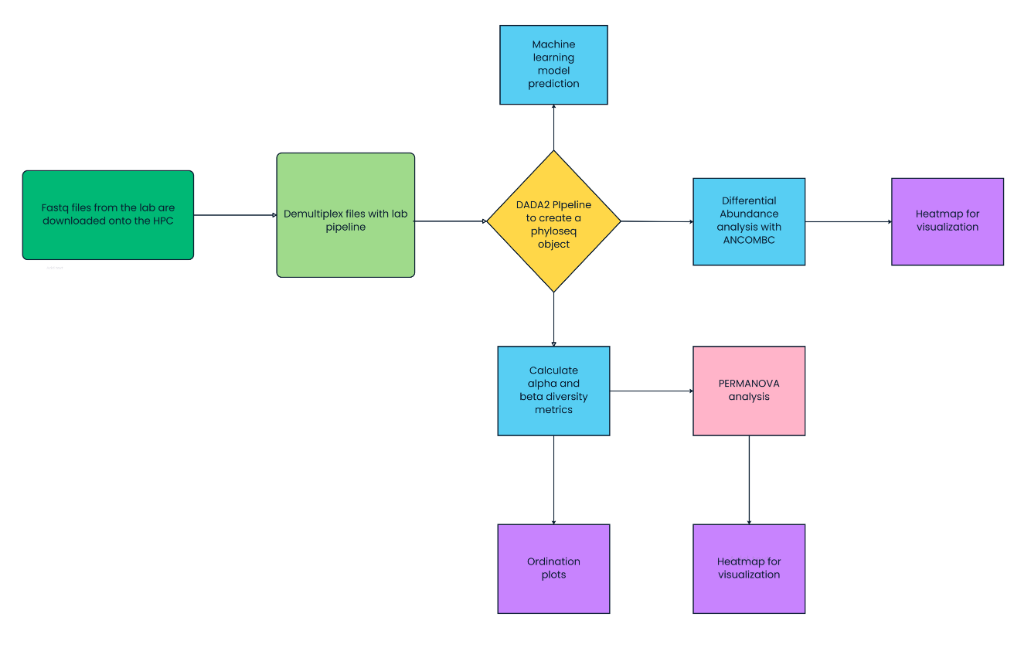

**Figure 1. Flowchart of Methods**

The above flow chart shows the overview of the project.

The 16S ribosomal RNA gene is highly conserved among bacteria, much of its sequence remains the same, but contains hypervariable regions that enable species-level identification. The gene's length makes it well-suited for Illumina sequencing, which generates short but highly accurate DNA reads. Because the 16S rRNA gene is unique to bacteria, it helps minimize interference from non-bacterial DNA contaminants. Additionally, since ribosomal genes evolve slowly, even bacteria that are not well characterized can be identified by comparing their sequences to known reference databases.

During the DNA amplification step, each sample is tagged with a unique DNA sequence called a Hamming barcode, which is attached to both the forward and reverse primers. These barcodes are carefully designed so that even if small sequencing errors occur, the barcodes remain distinct and can still correctly identify which DNA sequences came from which sample. This barcoding allows many samples to be combined and sequenced together in the same run, a process known as multiplexing, while still enabling accurate separation of data by sample afterward.

After sequencing, the raw data files (in FASTQ format) contain a mixture of sequences from all samples. A process called demultiplexing uses the unique barcode sequences to sort these mixed data back into individual sample files. This step is performed using a custom shell script provided by the research team (the script is in the below cell). The script is run on a high-performance computing cluster using the SLURM workload manager, which allows efficient handling of large datasets by distributing the computational tasks across many processors.

In [ ]:
#!/bin/bash
#Made by Mykhaylo Usyk MSci. 2022 mu408@nyu.edu

# module load novocraft/Oct20
PATH=/gs/gsfs0/users/burk-lab/Biosoftware/:$PATH
# module load prinseq-lite/0.20.4
PATH=/gs/gsfs0/users/burk-lab/BioSoftware_CZ/prinseq-lite-0.20.4/:$PATH

#Important directories/files
main_dir=$(pwd)

#Novobarcode path
#novo="/Users/LisaK/Desktop/ana/ana_test/BioSoftware/novocraft/novobarcode"
#prinseq="/Users/LisaK/Desktop/ana/ana_test/BioSoftware/prinseq-lite-0.20.4/prinseq-lite.pl"



#Set fancy fonts for the help message
NORM=`tput sgr0`
BOLD=`tput bold`
REV=`tput smso`


#Help
function HELP {
  echo "${BOLD}Help documentation for the Demultiplexer${NORM}"
  echo "Please specify the forward and reverse read locations"
  echo "Make sure to have a fastq directory with the forward and reverse reads in the same location as this script"
  echo "${REV}-f${NORM}   The location of the ${BOLD}forward reads${NORM}"
  echo "${REV}-r${NORM}   The location of the ${BOLD}reverse reads${NORM}"
  echo "${REV}-m${NORM}   The location of the ${BOLD}original mapping file${NORM}"
  echo "${REV}-s${NORM}   Passing this option skips the prinseq-lite step"
  echo "${REV}-h${NORM}   Displays this extremely helpful message and aborts script"
  echo "Example: sh general_demultiplex.sh${BOLD} -f fastq/forward_R1.fastq -r fastq/reverse_R1.fastq${NORM}"
  exit 1
}


#Check the number of arguments. If none are passed, print message and exit
NUMARGS=$#
if [ $NUMARGS -eq 0 ]; then
  echo "Did not pass any arguments, you probably need help\n"
  HELP
fi


# define the run type of this script
runtype="Everything"

#Parse the inputs
while getopts :f:r:m:hs FLAG; do
  case $FLAG in
    f)  #set option "f"
      OPT_f=$OPTARG
      ;;
    r)  #set option "r"
      OPT_r=$OPTARG
      ;;
    m)  #set option "m"
      OPT_m=$OPTARG
      ;;
    h)  #set option "h"
      OPT_p=$OPTARG
      HELP
      ;;
    s)  # prinseq skippy thing 
      runtype="PrinseqSkip"
      ;;
    \?) #unrecognized option - show help
      echo "Option -${BOLD}$OPTARG${NORM} not allowed."
      exit 1
      ;;
  esac
done




if [[ -z "$OPT_f" ]]; then
	echo "No forward read specified, aborting script"
	exit 1
fi

if [[ -z "$OPT_r" ]]; then
	echo "No reverse read specified, aborting script"
	exit 1
fi

if [[ -z "$OPT_m" ]]; then
	echo "No mapping file, aborting script"
	exit 1
fi


#Library variable
lib="libA"
mkdir ${main_dir}/fastq
cd ${main_dir}/fastq

if [ $runtype = "Everything" ]; then

echo "Full Pipe Selected, running prinseq-lite"

#Trimming the 3 bp buffers
prinseq-lite \
-fastq ${OPT_f} \
-fastq2 ${OPT_r} \
-out_format 3 \
-out_bad null \
-trim_left 3 \
-no_qual_header \
-out_good p29_${lib} \
-trim_qual_right 25 \
-trim_qual_left 25 \
-min_len 50 \
-verbose

# just doing a simple else without any kind of check, because I won't be adding any other runtype options (hopefully)
else 

echo "Skipping prinseq-lite step"

fi


cd ..

# create two folders for general reverse barcode demultiplexing #
mkdir -p ${main_dir}/novobarcode/p29_General_Barcode_Golay_P1/
mkdir -p ${main_dir}/novobarcode/p29_General_Barcode_Golay_P2/
mkdir -p ${main_dir}/novobarcode/log/


# demultiplex general (reverse) barcoded reads #
novobarcode_HPC \
-b ${main_dir}/general_barcode_p1.txt \
-d ${main_dir}/novobarcode/p29_General_Barcode_Golay_P1 \
-f ${main_dir}/fastq/p29_${lib}_1.fastq ${main_dir}/fastq/p29_${lib}_2.fastq \
--NC_OFF \
> ${main_dir}/novobarcode/log/p29_General_Barcode_Golay_P1_log.txt

novobarcode_HPC \
-b ${main_dir}/general_barcode_p2.txt \
-d ${main_dir}/novobarcode/p29_General_Barcode_Golay_P2 \
-f ${main_dir}/fastq/p29_${lib}_1.fastq ${main_dir}/fastq/p29_${lib}_2.fastq \
--NC_OFF \
> ${main_dir}/novobarcode/log/p29_General_Barcode_Golay_P2_log.txt

echo "Finished General Demultiplex"

cd ${main_dir}

#Library
lib="libA"

ReverseListPAP="${main_dir}/1_1_1_plate_barcodes.txt"

UniqueBCPAP="${main_dir}/1_1_3_forward.txt"
  

line_no=$(wc -l < $ReverseListPAP)
  
for i in $(seq 1 ${line_no}); do \
R_bc_list=$(sed "${i}q;d" $ReverseListPAP); \
Reverse_List_Name=($(echo "${R_bc_list}" | cut -d " " -f 1));\
Reverse_List_Seq=($(echo "${R_bc_list}" | cut -d " " -f 2)); \
echo "Processing ${Reverse_List_Name} demultiplexing ..."; \
mkdir -p ${main_dir}/novobarcode/${Reverse_List_Name}/; \
mkdir -p ${main_dir}/novobarcode/concatinated_reads_${lib}/; \
wait; \
cat ${main_dir}/novobarcode/p29_General_Barcode_Golay_P1/${Reverse_List_Seq}/p29_${lib}_1.fastq \
${main_dir}/novobarcode/p29_General_Barcode_Golay_P2/${Reverse_List_Seq}/p29_${lib}_2.fastq > \
${main_dir}/novobarcode/concatinated_reads_${lib}/p29_${lib}_${Reverse_List_Name}_P2.fastq; \
wait; \
cat ${main_dir}/novobarcode/p29_General_Barcode_Golay_P1/${Reverse_List_Seq}/p29_${lib}_2.fastq \
${main_dir}/novobarcode/p29_General_Barcode_Golay_P2/${Reverse_List_Seq}/p29_${lib}_1.fastq > \
${main_dir}/novobarcode/concatinated_reads_${lib}/p29_${lib}_${Reverse_List_Name}_P1.fastq; \
wait; \
novobarcode_HPC \
-b ${UniqueBCPAP} \
-d ${main_dir}/novobarcode/${Reverse_List_Name}/ \
-f ${main_dir}/novobarcode/concatinated_reads_${lib}/p29_${lib}_${Reverse_List_Name}_P1.fastq \
${main_dir}/novobarcode/concatinated_reads_${lib}/p29_${lib}_${Reverse_List_Name}_P2.fastq > \
${main_dir}/novobarcode/log/p29_${lib}_loop_${Reverse_List_Name}_log.txt; \
done

echo "Cleaning Up"

cd ${main_dir}/novobarcode
mkdir demultiplex_loop_1
mv Golay* demultiplex_loop_1/

echo "Done Forward Demultiplex"

cd ${main_dir}

sed '1d' ${OPT_m} > to_get_samples

mkdir samples

while read p
do 
sampleid=$(echo "${p}" | cut -f 1)
rev_bar=$(echo "${p}" | cut -f 4)
for_seq=$(echo "${p}" | cut -f 3)
mkdir samples/${sampleid}
cp novobarcode/demultiplex_loop_1/${rev_bar}/${for_seq}/* samples/${sampleid}
done < to_get_samples

cd samples

for f in */; do sampid=$(echo "${f}" | sed 's|/||1')
mv ${f}*P1.fastq ${f}${sampid}_R1.fastq
mv ${f}*P2.fastq ${f}${sampid}_R2.fastq
done

cd ${main_dir}

echo "Finished moving samples"


After demultiplexing, the forward-read FASTQ files (which contain the DNA sequences from the first read of each paired-end sequencing run) were processed using a modified version of the DADA2 pipeline in R. The original script was developed by Usyk and later modified by Gagler. This pipeline generates a high-quality amplicon sequence variant (ASV) table, which  lists all the unique bacterial DNA sequences found in each sample and shows how many times each sequence appears. 

Only the forward reads (R1) were used for this analysis. First, the sequences were truncated to 210 base pairs to ensure uniformity and to remove the lower-quality ends of reads. This step was performed using the filterAndTrim() function, which also filters out reads that do not meet quality criteria, removing low-quality or error-prone sequences.

Next, the DADA2 algorithm learns the error rates specific to the sequencing run from the filtered reads. DADA2 is a bioinformatics tool designed to accurately identify true bacterial DNA sequences by distinguishing them from sequencing errors, which is needed for reliable microbial analysis. This step models the types and frequencies of sequencing errors to accurately distinguish true biological sequences from errors. The algorithm then performs dereplication, where identical sequences are collapsed into unique representatives to reduce redundancy, and sample inference, which uses the error model to determine the true sequence variants present in each sample.

Following this, a sequence table is constructed that records the abundance of each unique ASV in every sample. Chimeric sequences are artifacts created during PCR when two different sequences are combined. They are identified and removed to prevent false positives.

For taxonomic classification, each ASV is compared to the SILVA database version 138 for reference and assigned bacterial identities at both the genus and species levels. Finally, the ASV abundance data and the taxonomic assignments are integrated into a single data object called a genus level phyloseq object in R, which facilitates downstream ecological and statistical analyses. This combined data object is saved as an .Rdata file for future use in the analysis workflow.

In [ ]:
# Original script made by Mykhaylo Usyk MSci. 2020 mu408@nyu.edu
# Modified to do R1 reads only by Dylan Gagler MSci. 2021 dylan.gagler@einsteinmed.org

if (!require("getopt")) {
  install.packages("getopt", dependencies = TRUE)
  library(getopt)
}
require("getopt", quietly=TRUE)

#Make all the flags
spec = matrix(c(
  "readloc" , "r", 1, "character",
  "outloc" , "o", 1, "character",
  "help", "h", 0, "logical",
  "trimlength", "l", 2, "numeric"
), byrow=TRUE, ncol=4)

opt = getopt(spec);

if (is.null(opt$help)) {
  help <- FALSE
} else {
  help <- opt$help
}

if (help) {
  print(
    cat("
        
        You have launched the help manual for DADA2 script that is intended to work on the Einstein clster
        To run alls you need are the paired end reads for all of the samples (in the same directory)
        
        -r where them reads are (use absolute path)
        -o where you want the phylo object to be written to (use absolute path)
        
        Optional Parameters
        -l The trim length for the forward and reverse reads (single value for both, defaults to 210)
        -h Help. Access the help option. Adding this option will cause the help manual to be shown and the 
        script aborted regardless of the other flags that have been added.
        
        "))
  quit()
}


library(dada2)
library(phyloseq)

setwd(opt$outloc)
# File parsing
path.reads <- opt$readloc # CHANGE ME to the directory containing your demultiplexed forward-read fastqs


read.size <- opt$trimlength

filtpath <- file.path(path.reads, "filtered") # Filtered forward files go into the pathF/filtered/ subdirectory

fastqFs <- sort(list.files(path.reads, pattern="R1.fastq"))

# Filtering: THESE PARAMETERS ARENT OPTIMAL FOR ALL DATASETS
filterAndTrim(fwd=file.path(path.reads, fastqFs), filt=file.path(filtpath, fastqFs),
              truncLen=read.size, verbose=TRUE, multithread=TRUE)


# now for the actual dada part
# File parsing
filtFs <- list.files(filtpath, pattern="R1.fastq", full.names = TRUE)
#filtRs <- list.files(filtpath, pattern="R2.fastq", full.names = TRUE)
sample.names <- sapply(strsplit(basename(filtFs), "_"), `[`, 1) # Assumes filename = samplename_XXX.fastq.gz
#sample.namesR <- sapply(strsplit(basename(filtRs), "_"), `[`, 1) # Assumes filename = samplename_XXX.fastq.gz

# logic check to make sure we have paired end data

names(filtFs) <- sample.names
#names(filtRs) <- sample.names
set.seed(12345)
# Learn forward error rates
errF <- learnErrors(filtFs, multithread=TRUE)
# Learn reverse error rates
#errR <- learnErrors(filtRs, multithread=TRUE)
# Sample inference and merger of paired-end reads
#mergers <- vector("list", length(sample.names))
#names(mergers) <- sample.names
# Making fwds
fwds <- vector("list", length(sample.names))
names(fwds) <- sample.names

for(sam in sample.names) {
  cat("Processing:", sam, "\n")
  derepF <- derepFastq(filtFs[[sam]])
  ddF <- dada(derepF, err=errF, multithread=TRUE)
  #derepR <- derepFastq(filtRs[[sam]])
  #ddR <- dada(derepR, err=errR, multithread=TRUE)
  #merger <- mergePairs(ddF, derepF, ddR, derepR)
  #mergers[[sam]] <- merger
  fwds[[sam]] <- ddF
}
rm(derepF)#; rm(derepR)
# Construct sequence table and remove chimeras
fwd.seqtab <- makeSequenceTable(fwds)

saveRDS(fwd.seqtab, "fwd_seqtab.rds")
##### Now for the final qc to remove the chimeras, assign taxonomy and what not

# Assign taxonomy
fwd.tax <- assignTaxonomy(fwd.seqtab, "/gs/gsfs0/users/burk-lab/DB/DADA2/silva_nr_v138_train_set.fa.gz", multithread=TRUE)
# Assign species
fwd.spec <- addSpecies(fwd.tax, "/gs/gsfs0/users/burk-lab/DB/DADA2/silva_species_assignment_v138.fa.gz")

fwd.spec <- phyloseq(otu_table(fwd.seqtab, taxa_are_rows=FALSE), tax_table(fwd.spec))

save(fwd.spec, file = "fwd.spec.ps.Rdata")

Alpha diversity measures the diversity within a single microbial community. This was assessed using the Shannon diversity index calculated from the phyloseq object produced by the above pipeline (object is named NG_gen_glom) containing genus-level taxonomic profiles. A higher Shannon diversity index means a sample has greater microbial diversity, with more species and/or a more even distribution of abundances. A lower Shannon diversity index means the microbial community is less diverse, often dominated by fewer species. Metadata (also provided by the lab) for 1,600 women was loaded and included cytokine and molecular BV data. The estimate_richness() function from the phyloseq package was used to compute Shannon diversity values, which were merged with sample metadata using participant IDs. Violin boxplots were generated using ggplot2 to visualize differences in Shannon diversity by molecular BV status and HPV category. Statistical comparisons between groups were performed using the stat_compare_means() function from ggpubr, and custom color palettes were applied for group-level differentiation.

In [ ]:
# By Tiffany Tang July 2025
# Run this everytime at the start
# Load in the libraries
library(phyloseq)
library(ggplot2)
library(ggpubr)
library(RColorBrewer)
# Set working directory
setwd("C:/Users/tiffa/OneDrive/Desktop/Masters in Bioinformatics/Capstone/Summer2025/Tiffany/tiffany_Nigeria")

# set up meta data for calculation of alpha diversity

meta_map <- read.csv(file = "../map_molBV_cyto_meta_910.txt", sep = "\t", as.is = T, quote = "")
# This step sets it up with the shipping and cytokine results
# for large data sets, when using read.csv we can use `as.is=T` to makesure that the data reads in without issue

# Get vectors of the column names: 
microbes <- c('Lactobacillus','Prevotella','Gardnerella','Megasphaera','Parvimonas','Clostridium','Porphyromonas','Adlercreutzia','Dialister','Atopobium','Sneathia')

# for cytokines: 
# Get all column names
all_cols <- colnames(meta_map)

# Select cytokine columns, exclude comments
cytokines <- grep("^HU_.*(?<!COMMENTS)$", all_cols, value = TRUE, perl = TRUE)

# Shannon index for alpha diversity
load("../NG_gen_glom.Robject")

diversity_test <- estimate_richness(physeq = NG_gen_glom, measures = c("Chao1", "Fisher", "Shannon"))

meta_map$Shannon <- diversity_test[meta_map$SID,"Shannon"]


ggplot(data = subset(meta_map, !is.na(molecularBV)), aes(x = molecularBV, y = Shannon, fill = molecularBV)) +
  geom_violin() +
  geom_boxplot(notch = T, width = 0.15, fill = "white") +
  theme_minimal() +
  stat_compare_means() +
  theme(legend.position = "bottom") +
  ggtitle("BV status vs. Shannon Diversity") +
  scale_fill_manual(values = c("#B57BA6", "#2F97C1", "#033F63"))  # Match to levels: BV, Intermediate, NoBV

# Shannon index for alpha diversity
load("../NG_gen_glom.Robject")

diversity_test <- estimate_richness(physeq = NG_gen_glom, measures = c("Chao1", "Fisher", "Shannon"))

meta_map$Shannon <- diversity_test[meta_map$SID,"Shannon"]


ggplot(data = subset(meta_map, !is.na(HPV_cat)), aes(x = HPV_cat, y = Shannon, fill = HPV_cat)) +
  geom_violin() +
  geom_boxplot(notch = T, width = 0.15, fill = "white") +
  theme_minimal() +
  stat_compare_means() +
  theme(legend.position = "bottom") +
  ggtitle("HPV type vs. Shannon Diversity") +
  scale_fill_manual(values = c("#B57BA6", "#2F97C1", "#033F63"))  # Match to levels: BV, Intermediate, NoBV


To investigate associations between microbial alpha diversity and immune signaling, Spearman correlation analyses were conducted between the Shannon diversity index and individual cytokine levels. Spearman correlation is a non-parametric measure of statistical dependence between two ranked variables. Spearman correlation was chosen for this study because it assesses monotonic relationships without requiring the data to be normally distributed or linearly related. This makes it well-suited for microbiome and cytokine data, which often exhibit non-normal distributions and contain outliers, allowing for more robust detection of biologically relevant associations. Before analysis, samples with missing Shannon diversity values were excluded, and cytokines with insufficient data (<10 non-missing values) were omitted. For each cytokine, a Spearman correlation coefficient (ρ) and associated p-value were calculated using the cor.test() function in R. To control for multiple comparisons, p-values were adjusted using the false discovery rate (FDR) method. The final correlation results were sorted by adjusted p-value to identify cytokines most significantly associated with microbiome diversity.

In [ ]:
# See if there is a correlation between the Shannon index and the cytokines
library(dplyr)

meta_map_clean <- meta_map[!is.na(meta_map$Shannon), ]

# Create a data.frame to store correlation results
cor_results <- data.frame(
  Cytokine = character(),
  Spearman_rho = numeric(),
  p_value = numeric(),
  stringsAsFactors = FALSE
)

# Loop through cytokines and compute Spearman correlation with Shannon
for (cyt in cytokines) {
  # Drop rows with NA in the cytokine
  temp_data <- meta_map_clean[!is.na(meta_map_clean[[cyt]]), ]
  
  # Check if there's enough data to compute correlation
  if (nrow(temp_data) > 10) {
    test <- suppressWarnings(cor.test(temp_data[[cyt]], temp_data$Shannon, method = "spearman"))

    
    cor_results <- rbind(cor_results, data.frame(
      Cytokine = cyt,
      Spearman_rho = test$estimate,
      p_value = test$p.value
    ))
  }
}

# Adjust p-values using FDR
cor_results$p_adj <- p.adjust(cor_results$p_value, method = "fdr")

# Use dplyr to sort and preserve column names
cor_results <- cor_results %>% arrange(p_adj)

# View results
print(cor_results)


Significant correlations between Shannon diversity and cytokine levels (FDR-adjusted p < 0.2, as recommended by Dr. Usyk) were visualized using bar plots. Cytokines passing the significance threshold were filtered using dplyr, and Spearman correlation coefficients were plotted using ggplot2. Bars were colored to indicate the direction of the correlation (positive or negative), and cytokines were ordered by effect size (Spearman’s ρ). The final plot was oriented horizontally for readability and included axis labels and a descriptive title to summarize the relationship between microbial diversity and host immune markers.

In [ ]:
## Plotting this correlation
library(dplyr)

# Filter for significant correlations
sig_all <- cor_results %>%
  filter(p_adj < 0.2) # Dr. Usyk told me to use 0.2

ggplot(sig_all, aes(x = reorder(Cytokine, Spearman_rho), y = Spearman_rho, fill = Spearman_rho > 0)) +
  geom_col() +
  coord_flip() +
  labs(title = "Significant Correlations with Shannon Diversity",
       x = "Cytokine",
       y = "Spearman's rho") +
  theme_minimal()

To visualize the full range of correlations between cytokine levels and Shannon diversity, a heatmap of Spearman correlation coefficients (ρ) was generated using ggplot2. The heatmap displayed all cytokines tested, regardless of significance, with Shannon diversity on the x-axis and cytokines on the y-axis. Color gradients represented the strength and direction of correlation, with blue indicating negative correlations, red indicating positive correlations, and white indicating no correlation (ρ ≈ 0). The color scale was centered at zero and bounded between -0.25 and 0.25 to highlight subtle correlation patterns. A minimal theme was applied for clarity, and axis text was adjusted for readability.

In [ ]:
# heatmap of the spearman Rho values
library(ggplot2)

# Create the heatmap-friendly data frame
ggplot(cor_results, aes(x = "Shannon", y = Cytokine, fill = Spearman_rho)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red",
                       midpoint = 0, limits = c(-0.25, 0.25),
                       name = "Spearman\nrho") +
  theme_minimal() +
  labs(title = "Correlation of Cytokines with Shannon Diversity",
       x = NULL,
       y = "Cytokine") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


To visually inspect the relationships between Shannon diversity and cytokines with suggestive significance (FDR-adjusted p < 0.2), scatter plots were generated for each cytokine using ggplot2. For each cytokine, individual scatter plots were created after filtering out missing values. Points were plotted with transparency to reduce overplotting and highlight potential data density. A linear regression line with a 95% confidence interval was overlaid using stat_smooth(method = "lm") to evaluate the direction and strength of the relationship. This approach helped assess potential outliers or nonlinear patterns that could bias correlation coefficients, particularly in datasets with sparse or zero-inflated values.

In [ ]:
# Scatter plot for alpha diversity 

# Use results with p_adj less than 0.2- suggested by Dr. Usyk
significant_cytokines <- cor_results$Cytokine[cor_results$p_adj < 0.2]

# Scatter plots with regression lines for the significant cytokines
library(ggpubr)  # for stat_compare_means()

for (cyt in significant_cytokines) {
  temp_df <- meta_map_clean[!is.na(meta_map_clean[[cyt]]), ]
  
  p <- ggplot(temp_df, aes_string(x = cyt, y = "Shannon")) +
    geom_point(alpha = 0.6) +  # show overlapping points better
    stat_smooth(method = "lm", color = "blue", se = TRUE) +  # regression line + CI
    theme_minimal() +
    ggtitle(paste("Scatter plot of Shannon Diversity vs.", cyt))
  
  print(p)
}


To further examine how Shannon diversity varied across different levels of cytokine expression, each cytokine with an FDR-adjusted p < 0.2 was divided into quartiles using the ntile() function from the dplyr package. For each cytokine, samples were grouped into four expression-based quartiles (Q1–Q4), and Shannon diversity was compared across these groups. Violin plots with overlaid boxplots were generated using ggplot2 to visualize distributional differences. Statistical comparisons between quartiles were performed using stat_compare_means() from the ggpubr package. This approach allowed for detection of non-linear trends or threshold effects in the relationship between cytokine levels and microbial diversity.

In [ ]:
# Grouping the cytokine levels into quartiles
# this uses dplyrs ntile() function 
# Box plot
library(dplyr)

for (cyt in significant_cytokines) {
  # Create quartiles for the cytokine
  temp_df <- meta_map_clean %>%
    filter(!is.na(.data[[cyt]])) %>%
    mutate(quartile = paste0("Q", ntile(.data[[cyt]], 4)))
  
  p <- ggplot(temp_df, aes(x = quartile, y = Shannon, fill = quartile)) +
    geom_violin(trim = FALSE) +
    geom_boxplot(width = 0.15, fill = "white") +
    stat_compare_means() +
    theme_minimal() +
    ggtitle(paste("Shannon Diversity by", cyt, "Quartiles")) +
    scale_fill_brewer(palette = "Set3") +
    theme(legend.position = "none")
  
  print(p)
}


Beta diversity was assessed using Principal Coordinates Analysis (PCoA) based on Bray-Curtis dissimilarity calculated from the phyloseq object (NG_gen_glom). PCoA is a dimensionality reduction technique that visualizes differences in microbial community composition by projecting high-dimensional distance matrices into a lower-dimensional space, typically two or three principal coordinate axes. This method was chosen because it allows for intuitive visualization of complex community structure and highlights patterns of similarity or dissimilarity among samples. The distance() function from phyloseq was used to compute Bray-Curtis distances, which are appropriate for ecological data as they emphasize differences in taxa abundance. Ordination was performed using the ordinate() function with the PCoA method. The resulting eigenvectors were extracted and merged with sample metadata using sample IDs. To visualize community composition differences, PCoA plots were generated using ggplot2, with points colored by molecular BV status. Samples with missing metadata were excluded from the plot. This ordination approach enabled the identification of clustering patterns in microbial communities associated with BV classification.

In [ ]:
## Ordination plot to look at clustering
library(phyloseq)
library(ggplot2)
library(vegan)

bray_dist <- distance(NG_gen_glom, method = "bray")
ord_pcoa <- ordinate(NG_gen_glom, method = "PCoA", distance = bray_dist)

ord_df <- as.data.frame(ord_pcoa$vectors)
ord_df$SampleID <- rownames(ord_df)

# merg the data 
merged_ord_meta <- merge(ord_df, meta_map, by.x = "SampleID", by.y = "SID", all.x = TRUE)

# try molecularBV
filtered_meta <- merged_ord_meta %>% filter(!is.na(molecularBV))

ggplot(filtered_meta, aes(x = Axis.1, y = Axis.2, color = molecularBV)) +
  geom_point(size = 3) +
  theme_minimal() +
  ggtitle("PCoA Plot with Metadata Coloring")


To assess whether variation in microbial community composition was associated with individual cytokine levels, permutational multivariate analysis of variance (PERMANOVA) was performed using the adonis2() function from the vegan package. PERMANOVA is a non-parametric method that tests whether the centroids (multivariate means) of groups differ significantly in a multivariate space, based on a distance matrix. It is particularly useful for ecological data because it does not assume normality and can handle high-dimensional, sparse, or compositional datasets, such as microbiome profiles. Bray-Curtis dissimilarity was calculated from the genus-level phyloseq object and aligned with corresponding metadata. For each cytokine, samples with missing values were excluded, and the distance matrix was subset accordingly. PERMANOVA was run with 999 permutations to test the association between each cytokine and the microbial community structure. R² values and p-values were extracted and summarized for all cytokines, with significance defined as p < 0.05. Only cytokines with statistically significant associations were retained for further interpretation.

In [ ]:
library(vegan)

# Match metadata to distance matrix
meta <- meta_map[match(labels(bray_dist), meta_map$SID), ]

#  Create an empty list to store results
permanova_results <- list()

# SLoop through each cytokine
for (cytokine in cytokines) {
  # Filter out rows with missing values for the current cytokine
  meta_clean <- meta[!is.na(meta[[cytokine]]), ]
  
  # Skip if too few samples remain
  if (nrow(meta_clean) < 10) next
  
  # Subset the distance matrix
  samples_keep <- meta_clean$SID
  bray_sub <- as.dist(as.matrix(bray_dist)[samples_keep, samples_keep])
  
  # Re-align metadata
  meta_clean <- meta_clean[match(labels(bray_sub), meta_clean$SID), ]
  
  # Run PERMANOVA
  adonis_out <- adonis2(bray_sub ~ meta_clean[[cytokine]], permutations = 999)
  
  # Store result
  permanova_results[[cytokine]] <- adonis_out
}

# Print results
for (cytokine in names(permanova_results)) {
  cat("\n===== PERMANOVA for", cytokine, "=====\n")
  print(permanova_results[[cytokine]])
}
# Significant ones only

# Extract p-values and R²s into a summary data frame
result_summary <- data.frame(
  Cytokine = names(permanova_results),
  R2 = sapply(permanova_results, function(x) x$R2[1]),
  p_value = sapply(permanova_results, function(x) x$`Pr(>F)`[1])
)

# Filter for significant ones
significant_results <- result_summary[result_summary$p_value < 0.05, ]

# View significant cytokines
print(significant_results)

Differential abundance analysis of microbial taxa in relation to cytokine levels was performed using the ANCOM-BC2 method. ANCOM-BC2 (Analysis of Composition of Microbiomes with Bias Correction, version 2) is a statistical tool specifically developed for differential abundance testing in compositional microbiome data, where microbial counts are relative rather than absolute due to sequencing depth constraints. Unlike older methods such as DESeq2, ANCOM-BC2 includes bias correction steps to adjust for sampling variability, controls the false discovery rate more effectively, and accounts for the compositional nature of the data, thereby reducing the likelihood of false positives. This makes it especially suitable for microbiome studies, where comparing the relative abundance of taxa across conditions is prone to distortion without appropriate normalization and bias correction.

For this study, the cytokine expression levels were dichotomized into “High” and “Low” groups based on the median value for each cytokine to create balanced comparison groups. Taxonomic count data and cytokine metadata were formatted into a phyloseq object, which integrates sequencing data with sample and taxonomic metadata for downstream analysis. ANCOM-BC2 was run iteratively for each cytokine group using default parameters, including Benjamini-Hochberg adjustment for multiple testing and prevalence and library size cutoffs to exclude rare or low-abundance taxa. Significant taxa showing differential abundance between “High” and “Low” cytokine groups were identified using a false discovery rate (FDR) threshold of 0.05.

In [ ]:
#Separate out the taxa and counts
microbe_data<- meta_map[, microbes]
rownames(microbe_data) <- meta_map$SID

cytokine_data<- meta_map[, cytokines]
rownames(cytokine_data) <- meta_map$SID

dim(cytokine_data)

# Make a copy of cytokine_data to hold all groupings
cytokine_groups <- cytokine_data

# Initialize a vector to store group column names
group_col_names <- c()

# Loop through each cytokine name in your list
for (cytokine in cytokines) {
  group_col <- paste0(cytokine, "_group")
  
  # Extract the data for this cytokine
  values <- cytokine_groups[[cytokine]]
  
  # Calculate the median (ignoring NA)
  med <- median(values, na.rm = TRUE)
  
  # Create group: "Low" if <= median, "High" if > median
  cytokine_groups[[group_col]] <- ifelse(
    is.na(values), NA,
    ifelse(values <= med, "Low", "High")
  )
     # Store the group column name
  group_col_names <- c(group_col_names, group_col)
}
# Set up phyloseq object
# Load library
library(ANCOMBC)
library(phyloseq)

otu_subset <- as.data.frame(t(microbe_data)) # Rows are taxa
meta_subset <- cytokine_groups

# Convert OTU matrix to phyloseq otu_table
otu_phy <- otu_table(otu_subset, taxa_are_rows = TRUE)

# Make sure meta_subset rownames are sample IDs 
# Convert metadata dataframe to sample_data object
meta_phy <- sample_data(meta_subset)

# Create phyloseq object
ps <- phyloseq(otu_phy, meta_phy)

# Check the object
ps

# Fixed ANCOMBC2 loop
library(phyloseq)
library(ANCOMBC)

# Initialize storage
results_list <- list()

# Loop through cytokine groups
for(cytokine in group_col_names) {
  
  cat("Processing:", cytokine, "\n")
  
  # ANCOM-BC2
  res2 <- ancombc2(
    data = ps,
    assay_name = "counts",
    tax_level = NULL,
    fix_formula = cytokine,
    rand_formula = NULL,
    p_adj_method = "BH",
    prv_cut = 0.1,
    lib_cut = 1000,
    s0_perc = 0.05,
    group = cytokine,
    struc_zero = FALSE,
    neg_lb = TRUE,
    alpha = 0.05,
    n_cl = 1
  )
  
  # Extract results
  res_df2 <- res2$res
  
  # Find the correct q-value column
  q_cols <- grep("^q_", colnames(res_df2), value = TRUE)
  q_col <- q_cols[!grepl("Intercept", q_cols)][1]  # Get first non-Intercept q column
  
  significant_taxa2 <- res_df2$taxon[res_df2[[q_col]] < 0.05] # significance will be less than 0.05!
  cat("Significant taxa found:", length(significant_taxa2), "\n")
  if(length(significant_taxa2) > 0) {
    print(significant_taxa2)
  }
  
  # Store results
  results_list[[cytokine]] <- res2
}

To visualize differential abundance patterns of microbial taxa significantly associated with cytokine levels, a heatmap of log2 fold changes was generated using the pheatmap package. Significant taxa across all cytokines were identified by aggregating taxa with false discovery rate (FDR)-adjusted p-values below 0.05 from ANCOM-BC2 results. A matrix of log2 fold changes was constructed with taxa as rows and cytokine group comparisons as columns, assigning zero for non-significant taxa. Hierarchical clustering was applied to both rows and columns to reveal patterns of co-association among taxa and cytokines. The heatmap employed a blue-white-red color gradient to represent decreases, no change, and increases in relative abundance, respectively, facilitating visual interpretation of microbial shifts related to immune signaling.

In [ ]:
library(pheatmap)

#Get all significant taxa across all cytokines
all_sig_taxa <- unique(unlist(lapply(results_list, function(res) {
  df <- res$res
  q_col <- grep("^q_", colnames(df), value = TRUE)
  q_col <- q_col[!grepl("Intercept", q_col)][1]
  df$taxon[df[[q_col]] < 0.05]
})))

# Build log2 fold change matrix
# initiate with 0
lfc_matrix <- matrix(0, nrow = length(all_sig_taxa), ncol = length(results_list))
rownames(lfc_matrix) <- all_sig_taxa
colnames(lfc_matrix) <- names(results_list)

# Fill in the matrix
for (cytokine in names(results_list)) {
  df <- results_list[[cytokine]]$res
  q_col <- grep("^q_", colnames(df), value = TRUE)
  q_col <- q_col[!grepl("Intercept", q_col)][1]
  lfc_col <- grep("^lfc_", colnames(df), value = TRUE)
  lfc_col <- lfc_col[!grepl("Intercept", lfc_col)][1]
  
  sig_df <- df[df[[q_col]] < 0.05, ]
  lfc_matrix[sig_df$taxon, cytokine] <- sig_df[[lfc_col]]
}

# Make the heatmap
pheatmap(
  lfc_matrix,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  na_col = "grey90",
  color = colorRampPalette(c("blue", "white", "red"))(50),
  main = "Log2 Fold Change of Significant Taxa (ANCOM-BC2)",
  fontsize_row = 8,
  fontsize_col = 10
)


Spearman correlation analyses were performed to evaluate associations between cytokine expression levels and microbial genus abundances. Spearman correlation is a non-parametric statistical method that measures the strength and direction of a monotonic relationship between two variables, meaning it assesses whether one variable tends to increase or decrease consistently as the other changes, without assuming a linear relationship of the data. It's useful for biological data, like cytokine levels and microbial abundances, which often have outliers or non-normal distributions. Cytokine and microbial count data were extracted from the metadata and aligned by sample IDs to ensure matching samples. Pairwise Spearman correlation coefficients and corresponding p-values were computed for all cytokine–taxa combinations using the cor.test() function in R, with warnings suppressed. Multiple testing correction was applied to the p-values using the false discovery rate (FDR) method. Correlations not meeting the significance threshold of FDR-adjusted p < 0.05 were set to NA, allowing identification of statistically significant positive or negative associations between host immune markers and microbial taxa.

In [ ]:
# Spearman correlation between cytokines and taxa

# Set up data
cyto_data <- meta_map[,cytokines]
rownames(cyto_data) <- meta_map$SID

taxa_data <- meta_map[, microbes]
rownames(taxa_data) <- meta_map$SID

# Ensure sample IDs match and are aligned
cyto_data <- cyto_data[rownames(taxa_data), ]  # Align rows
taxa_data <- taxa_data[rownames(cyto_data), ]

# Create empty matrices for correlation and p-values
cor_mat <- matrix(NA, nrow = ncol(cyto_data), ncol = ncol(taxa_data))
pval_mat <- matrix(NA, nrow = ncol(cyto_data), ncol = ncol(taxa_data))

rownames(cor_mat) <- colnames(cyto_data)
colnames(cor_mat) <- colnames(taxa_data)
rownames(pval_mat) <- colnames(cyto_data)
colnames(pval_mat) <- colnames(taxa_data)

# Compute Spearman correlations
for (i in seq_len(ncol(cyto_data))) {
  for (j in seq_len(ncol(taxa_data))) {
    test <- suppressWarnings(cor.test(cyto_data[[i]], taxa_data[[j]], method = "spearman"))
    cor_mat[i, j] <- test$estimate
    pval_mat[i, j] <- test$p.value
  }
}

# FDR adjust p-values
pval_adj <- matrix(p.adjust(pval_mat, method = "fdr"), nrow = nrow(pval_mat),
                   dimnames = dimnames(pval_mat))

# filter to significant correlations
cor_sig <- cor_mat
cor_sig[pval_adj > 0.05] <- NA  # Keep only significant correlations

#cor_sig

To visually summarize the significant correlations between cytokines and microbial taxa, a heatmap was generated using the pheatmap package. Missing values (non-significant correlations) in the correlation matrix were replaced with zero to distinguish them from positive or negative correlations. The heatmap applied a diverging red-to-blue color palette (from RColorBrewer) to represent the direction and magnitude of Spearman correlation coefficients, with hierarchical clustering performed on both cytokines (rows) and taxa (columns). This visualization facilitated identification of co-association patterns between host immune factors and microbiome composition.

In [ ]:
# Replace NA with 0 in significant correlation matrix for plotting
cor_sig_plot <- cor_sig
cor_sig_plot[is.na(cor_sig_plot)] <- 0

library(pheatmap)
library(RColorBrewer)

# Plot heatmap of significant correlations (0 = non-significant)
pheatmap(cor_sig_plot,
         color = colorRampPalette(rev(brewer.pal(11, "RdBu")))(100),
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         main = "Spearman Correlations: Cytokines vs Microbial Taxa",
         na_col = "grey80",
         fontsize_row = 10,
         fontsize_col = 10)

To predict bacterial vaginosis (BV) status from combined microbiome and cytokine data, a machine learning classification pipeline was implemented in Python. Metadata were loaded and samples with missing BV status were excluded to ensure that all data used had known outcomes for accurate model training and evaluation. Features consisted of cytokine levels and relative abundances of key microbial genera, chosen because both immune signaling and microbial composition are thought to influence BV status. Cytokine data were log-transformed using log1p to reduce skewness and handle zero values, then standardized with StandardScaler to ensure that all features contributed equally to the model regardless of their original scale. Microbial counts were converted to relative abundances per sample to account for differences in sequencing depth between samples, scaled by 1,000,000 to avoid very small decimal values that can cause computational issues, then log-transformed and standardized similarly to the cytokine data to normalize distributions and facilitate model learning. The processed cytokine and microbial feature matrices were concatenated into a single feature set to integrate both biological data types for more comprehensive prediction. The dataset was split into training (80%) and testing (20%) subsets, stratified by BV status to preserve the original distribution of classes and prevent bias, using a fixed random seed to ensure reproducibility of results across runs.

In [ ]:
# Run this chunk first every day!

# import libraries
import pandas as pd
import numpy as np
import re

# Set working directory 
import os
os.chdir("C:/Users/tiffa/OneDrive/Desktop/Masters in Bioinformatics/Capstone/Summer2025/Tiffany/tiffany_Nigeria")
# Read the metadata file
meta_map = pd.read_csv("../map_molBV_cyto_meta_910.txt", sep="\t", quotechar='"')

# Define list of microbes (same as your R vector)
microbes = ['Lactobacillus', 'Prevotella', 'Gardnerella', 'Megasphaera',
            'Parvimonas', 'Clostridium', 'Porphyromonas', 'Adlercreutzia',
            'Dialister', 'Atopobium', 'Sneathia']

# Extract cytokine column names using regex to match those starting with 'HU_' but excluding those ending with 'COMMENTS'
all_cols = meta_map.columns.tolist()
cytokines = [col for col in all_cols if re.match(r'^HU_.*(?<!COMMENTS)$', col)]
# Define variables X and Y for ML
# Drop rows where target is missing
meta_map = meta_map.dropna(subset=['molecularBV'])

# Define target variable y as categorical
y = meta_map['molecularBV'].astype('category')

# Extract cytokine features
X_cyto = meta_map[cytokines]

# Extract microbial taxa features
X_microbe = meta_map[microbes]

from sklearn.preprocessing import StandardScaler

# Need to scale and pre process the data
# Cytokines log1p transform + scale
X_cyto_log = np.log1p(X_cyto)
scaler_cyto = StandardScaler()
X_cyto_scaled = scaler_cyto.fit_transform(X_cyto_log)

# Microbes convert counts to relative abundance by row, fill NA with 0
X_microbe_relab = X_microbe.div(X_microbe.sum(axis=1), axis=0).fillna(0)

# log1p transform scaled relative abundance (multiply by 1e6 to avoid tiny values)
X_microbe_log = np.log1p(X_microbe_relab * 1e6)
scaler_microbe = StandardScaler()
X_microbe_scaled = scaler_microbe.fit_transform(X_microbe_log)

# Combine processed features
X_preprocessed = np.hstack([X_cyto_scaled, X_microbe_scaled])

#feature names combined for future reference
feature_names = cytokines + microbes
# Train/ test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

A Random Forest classifier was trained to predict bacterial vaginosis status using the combined microbiome and cytokine feature set. The model was implemented with the RandomForestClassifier from scikit-learn using a fixed random seed for reproducibility. The classifier was trained on the training dataset and evaluated on the held-out test set. Performance metrics including precision, recall, F1-score, and overall accuracy were calculated using the classification_report function. A confusion matrix was also generated to assess the model’s classification errors and true positives/negatives.

In [ ]:
# I will run Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Look at the results
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Feature importance scores from the trained Random Forest classifier were extracted to identify the most influential cytokines and microbial taxa in predicting bacterial vaginosis status. Using matplotlib, a horizontal bar plot was generated displaying the relative importance of each feature, allowing visualization of which variables contributed most to the model’s decision-making process.

In [ ]:
# Feature importance plot
import matplotlib.pyplot as plt

importances = clf.feature_importances_
plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


To evaluate the multi-class classification performance of the Random Forest model trained on combined cytokine and microbial features, we conducted a Receiver Operating Characteristic (ROC) analysis and computed class-specific Area Under the Curve (AUC) scores. Since bacterial vaginosis (BV) status consisted of three categories ("BV", "Intermediate", and "NoBV"), a one-vs-rest (OvR) strategy was implemented to facilitate multi-class ROC evaluation.

Class labels were first binarized using the label_binarize function from scikit-learn, resulting in a one-hot encoded representation of the target variable. A OneVsRestClassifier wrapper was applied around the RandomForestClassifier to enable probabilistic predictions for each class. The model was trained on the binarized training labels, and predicted class probabilities were obtained for the test set.

For each class, ROC curves were constructed by plotting the true positive rate (sensitivity) against the false positive rate (1 – specificity) across a range of classification thresholds. The AUC was then calculated as a summary metric representing the model’s ability to discriminate each class from the rest, with values closer to 1.0 indicating superior performance and a value of 0.5 representing random chance.

All ROC curves were visualized on a single plot, with separate curves and corresponding AUC scores for each class. A diagonal dashed line was included to denote the performance of a random classifier (AUC = 0.5). This ROC-AUC framework provided a threshold-independent evaluation of classifier performance, particularly useful for multi-class and imbalanced datasets where traditional accuracy metrics may be insufficiently informative.



In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output labels for multi-class ROC
# Get class names from y_train (categories)
class_names = y.cat.categories.tolist()

# Binarize labels: shape (n_samples, n_classes)
y_train_bin = label_binarize(y_train, classes=class_names)
y_test_bin = label_binarize(y_test, classes=class_names)

# Re-train with OneVsRestClassifier wrapper to get probability estimates for each class
ovr_clf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
ovr_clf.fit(X_train, y_train_bin)

# Predict class probabilities on test set
y_score = ovr_clf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['cyan', 'orange', 'blue']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves for Random Forest Model (Cytokines + Microbes)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

To assess the predictive utility of only the cytokine profiles for bacterial vaginosis (BV) status, a Random Forest classifier was trained using only cytokine features. Cytokine concentrations were first log-transformed using a log1p function to normalize skewed distributions, followed by standard scaling to ensure comparability across features. The dataset was then split into training (80%) and testing (20%) sets, stratified by BV class (BV, Intermediate, and NoBV) to preserve class balance during model evaluation.

The classifier was trained on the cytokine-only dataset, and performance was assessed on the held-out test set using traditional classification metrics, including accuracy, precision, recall, and F1-score, along with confusion matrices. Feature importance scores were extracted from the trained model to identify which cytokines contributed most to classification accuracy; these were visualized using a horizontal bar plot.

Again, to further evaluate the model’s discriminative performance across the three BV status classes, Receiver Operating Characteristic (ROC) curves and Area Under the Curve (AUC) scores were computed again using a one-vs-rest (OvR) strategy. To separate ROC curve for each class by comparing it against the combination of all other classes, allowing for a granular and robust multi-class assessment. The ROC curves plot sensitivity (true positive rate) against specificity (false positive rate) across all classification thresholds, while the AUC provides a threshold-independent scalar measure of classification performance.

In [ ]:
# Running on just cytokine features
X_cyto_only = meta_map[cytokines]

# Preprocess cytokines: log1p + standard scale
import numpy as np
from sklearn.preprocessing import StandardScaler

X_cyto_log = np.log1p(X_cyto_only)
scaler_cyto = StandardScaler()
X_cyto_scaled = scaler_cyto.fit_transform(X_cyto_log)

# Use this as feature matrix
X_preprocessed_cyto = X_cyto_scaled

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_cyto, y, test_size=0.2, stratify=y, random_state=42)

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained model
importances = clf.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_features = [cytokines[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances (Cytokines Only)")
plt.barh(range(len(sorted_importances)), sorted_importances[::-1], color="skyblue", align="center")
plt.yticks(range(len(sorted_importances)), sorted_features[::-1])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ROC curces and AUC score code

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np

# Binarize the output labels (needed for multi-class ROC/AUC)
classes = y.cat.categories.tolist()  # your categories in order, e.g. ['BV', 'Intermediate', 'NoBV']
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities for each class
y_score = clf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_name in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Results and Discussion

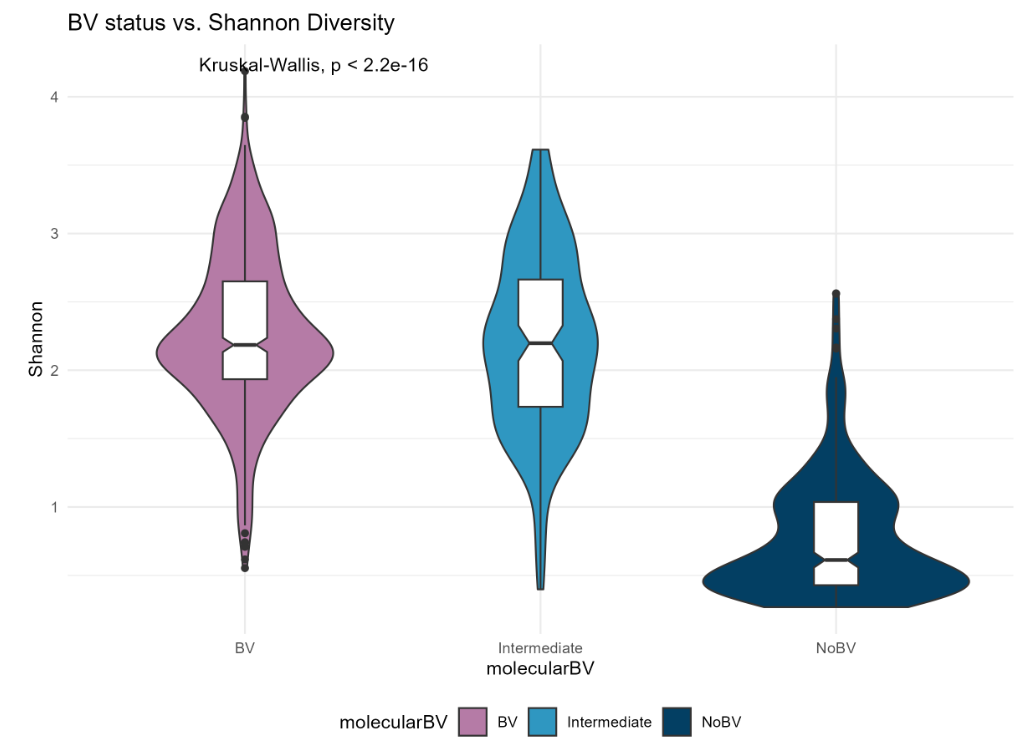

**Figure 2. BV vs Shannon Diversity Plot**

This violin plot illustrates differences in Shannon diversity across three molecular BV (bacterial vaginosis) status groups: BV, Intermediate, and NoBV. Shannon diversity is a measure of microbiome alpha diversity that accounts for both richness (number of different species) and evenness (relative abundance of species). A higher Shannon diversity index indicates a more diverse microbiome—one that contains a greater number of species that are more evenly distributed. From this plot, we can see there is a clear correlation between the Shannon diversity index and the presence of BV. These results suggest that BV is associated with significantly higher microbial diversity, whereas healthy (NoBV) vaginal microbiomes tend to be less diverse and more dominated by a few species, typically Lactobacillus. The intermediate group, with diversity values spanning both ends, may represent a transitional or heterogeneous microbial state. BV samples show a bimodal distribution, with a peak around 2 and a smaller secondary peak closer to 3, indicating possible subgroups or compositional differences within BV-positive individuals.

To assess the statistical significance of these differences, we applied the Kruskal-Wallis test, a non-parametric method used to compare medians across more than two groups. The result (p < 2.2e-16) indicates that the observed differences in Shannon diversity among the BV, Intermediate, and NoBV groups are highly statistically significant and unlikely to have occurred by chance.

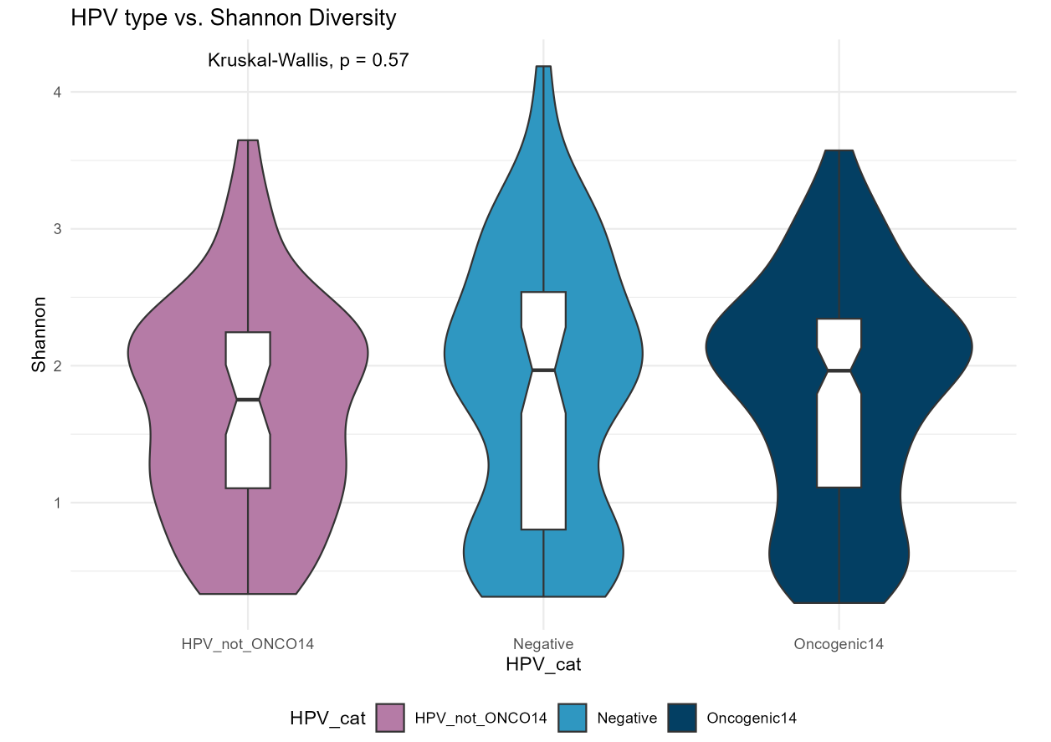

**Figure 3. HPV Status versus Shannon Diversity**

The plot in Figure 3 suggest that HPV status or HPV type is not associated with significant differences in vaginal microbiome diversity as measured by the Shannon index. This contrasts with findings from BV status, where diversity varied markedly between groups. It may indicate that HPV infection alone does not strongly influence overall microbial diversity, or that other factors (e.g., BV, inflammation, host immune response) may play a larger role.

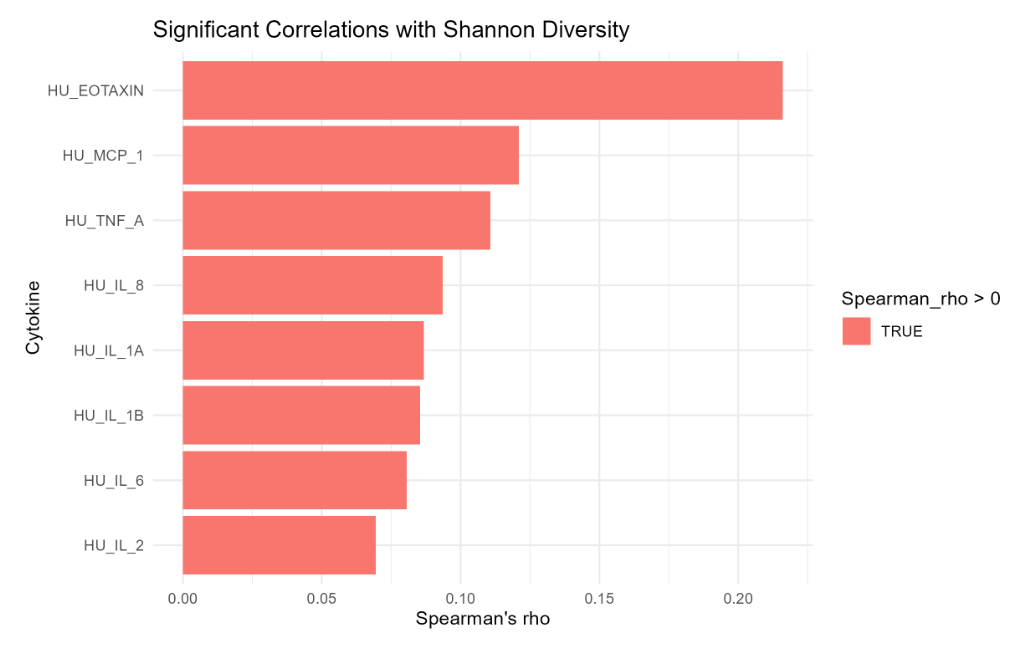

**Figure 4. Significant Cytokines Correlations Plot**

This bar plot in Figure 4 displays the significant Spearman correlations between various cytokines and Shannon diversity, a common measure of microbial alpha diversity. All of the significant cytokines have a positive correlation with Shannon Diversity. Each bar represents a cytokine that showed a statistically significant positive correlation (FDR-adjusted p-value < 0.05) with Shannon diversity. The length of the bar reflects the strength of the correlation (Spearman’s rho), indicating how strongly the cytokine levels are associated with microbial diversity. Notably, HU_EOTAXIN shows the strongest positive correlation, followed by HU_MCP_1, HU_TNF_A, and several interleukins (e.g., IL_8, IL_1A, IL_1B, IL_6). This suggests that higher microbial diversity may be linked with elevated levels of these inflammatory or immune-related cytokines.

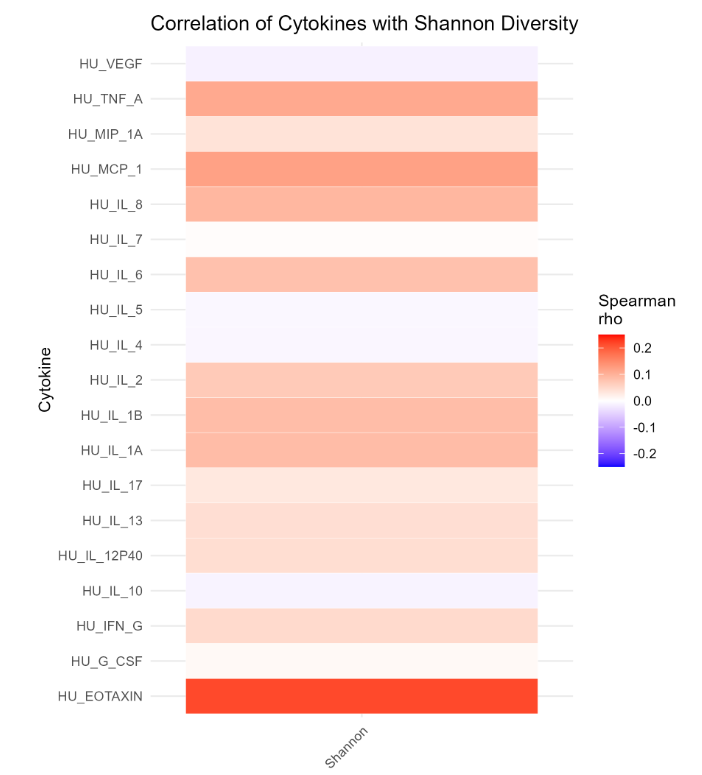

**Figure 5. Shannon Diversity and Cytokine Correlation Heatmap**

Figure 5 shows the Spearman correlation coefficients (rho) between levels of various cytokines and Shannon diversity, a measure of microbiome alpha diversity. Most cytokines show a weak positive correlation with Shannon diversity, indicated by light red to pink shades. This suggests that as cytokine levels increase, microbial diversity also tends to increase, though modestly. The strongest positive correlation is seen with HU_EOTAXIN, which is marked in bright red, suggesting a more notable association between Eotaxin levels and increased microbial diversity. A few cytokines (e.g., HU_VEGF, HU_IL_10) appear almost white or light purple, suggesting very weak or slightly negative correlations, though these are still close to zero and likely not meaningful. No cytokines exhibit strong negative correlations, and the overall scale is centered around mild rho values, between approximately −0.1 and +0.3. Most correlations are weak, implying that cytokine levels are not strong standalone predictors of microbial diversity in this dataset.

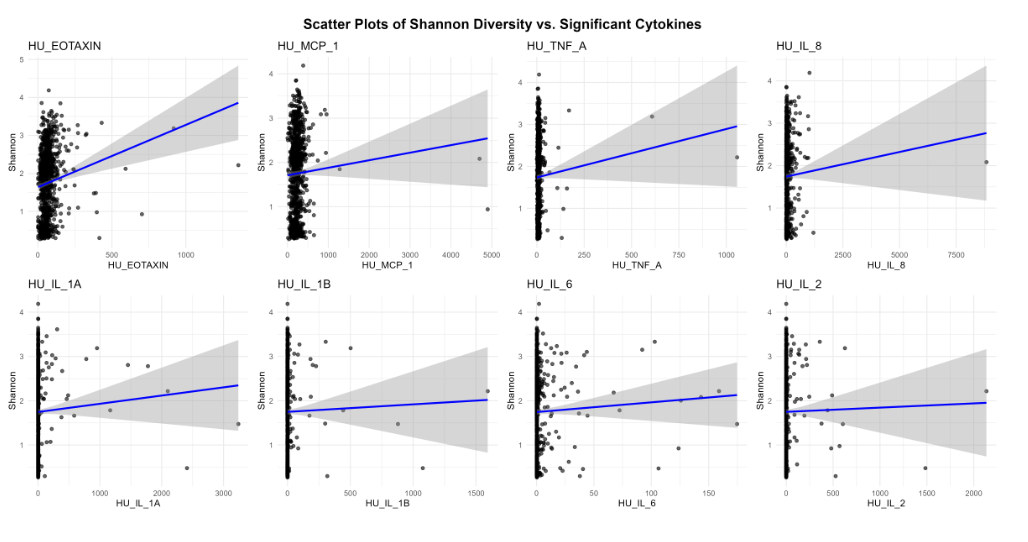

**Figure 6. Scatter Plots of Shannon Diversity vs Individual Significant Cytokines**

We can see from these scatter plots in Figure 6 that the confidence intervals widen as the cytokine levels increase, this suggests greater uncertainty in the model's prediction, which is most likely due to fewer data points in that range. We can also see in most of these plots that most of the datapoints are clustered at the lower levels. While we detect a trend between cytokine level and microbiome diversity primarily at low-to-moderate cytokine values, interpretations for very high levels should be made cautiously. The scatter plots also affirm what we see with the Spearman correlation, HU_EOTAXIN has the largest positive slope, while the other significant cytokines have a weaker, but still positive slope.

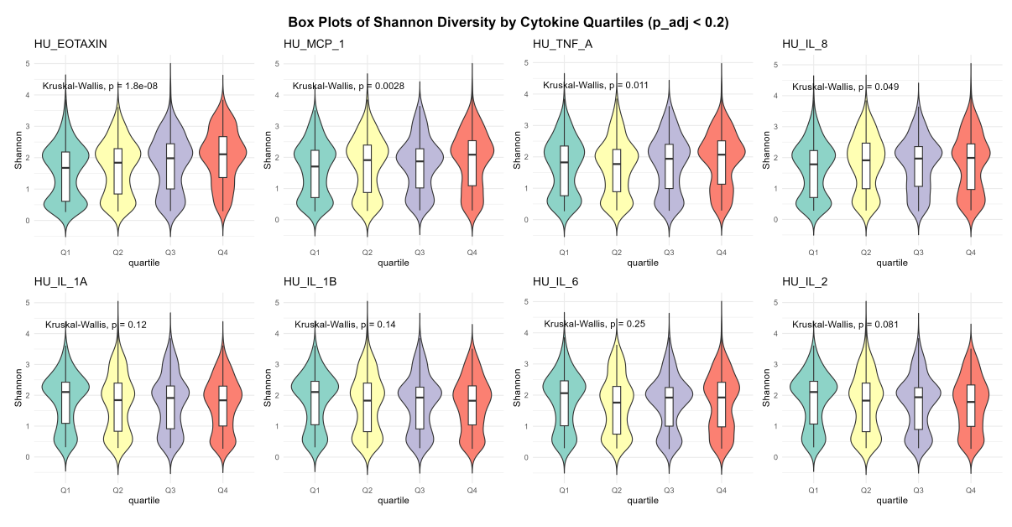

**Figure 7. Shannon Diversity by Cytokine Quartile Violin Boxplots**

In Figure 7 we can see that for HU_EOTAXIN we can see that throughout the quartiles there is an increase in Shannon diversity as cytokine levels increase (this is consistent with out other analyses). Interestingly, the first 3 quartiles appear bimodal and the last quartile is unimodal. 

For HU_MCP_1 there is a slight positive upward trend, as cytokine levels increase Shannon Diversity index slightly increases, which is still consistent with our other analyses.

For HU_TNF_A the first two quartiles appear to have the same Shannon Diversity index for the median, but the last two quartiles trend upward. 

For HU_IL_8, the medians slightly trend upward and the third quartile appears unimodal. 

For HU_IL_1A, HU_IL_1B, HU_IL_6 and HU_IL_2 the Kruskal-Wallis p-values are all greater than 0.05. This appears to contrast with the scatter plots and Spearman correlations, which indicate a potential trend between cytokine levels and alpha diversity. One  reason for this discrepancy is that linear regression and Spearman correlation analyses are more sensitive to outliers or skewed distributions. In contrast, the Kruskal-Wallis test, being a non-parametric method that compares group medians, is more robust to extreme values and may not detect subtle or continuous trends unless differences between groups are strong and consistent. 

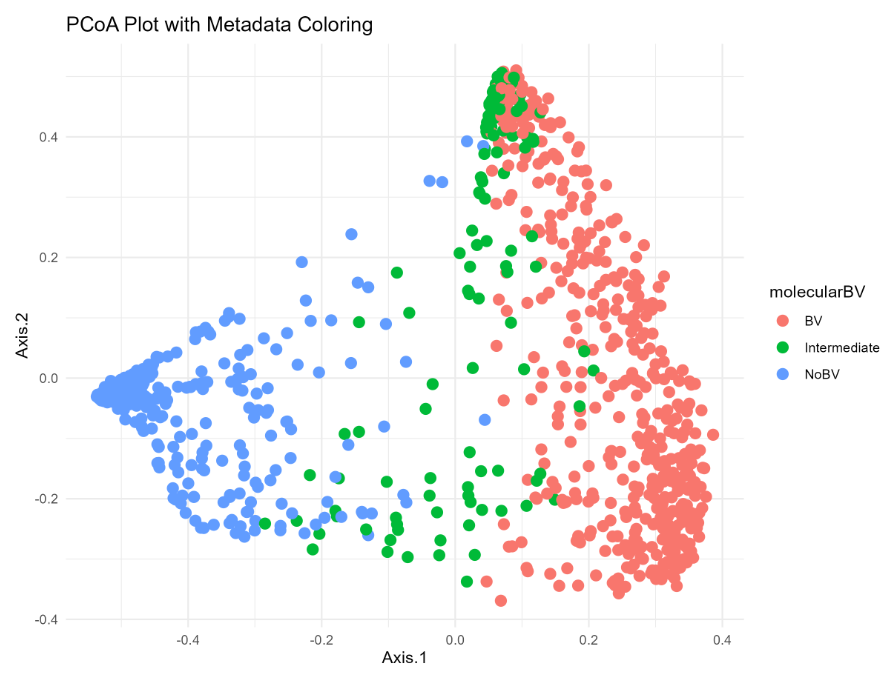

**Figure 8. PCoA Plot**

This PCoA plot in Figure 8 shows that microbiome composition differs significantly across molecularBV groups. Axis.1 captures most of this variation, effectively separating NoBV from BV, with Intermediate samples lying in between, suggesting a microbiome continuum from healthy to dysbiotic states. Axis 2 shows some separation between NoBV and both BV and Intermediate groups, but little to no separation between BV and Intermediate along this axis. This suggests that while Axis 1 reflects the main gradient of dysbiosis, Axis 2 may capture subtler compositional differences unrelated to the BV/Intermediate distinction.

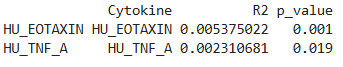

**Table 1. Permanova Significant Cytokines**

The PERMANOVA results in Table 1 indicate that levels of the cytokines HU_EOTAXIN and HU_TNF_A are significantly associated with differences in microbial community composition. Specifically, HU_EOTAXIN has a p-value of 0.001 and HU_TNF_A has a p-value of 0.019, both below the 0.05 threshold for statistical significance. This means that variation in these cytokines corresponds to detectable changes in the microbiome. However, the R² values are very low:0.0054 for HU_EOTAXIN and 0.0023 for HU_TNF_A, indicating that each cytokine explains less than 1% of the variation in microbial composition. While the associations are statistically significant, the effect sizes are small, suggesting that these cytokines have a real but modest influence on the microbiome and likely act alongside other host and environmental factors.

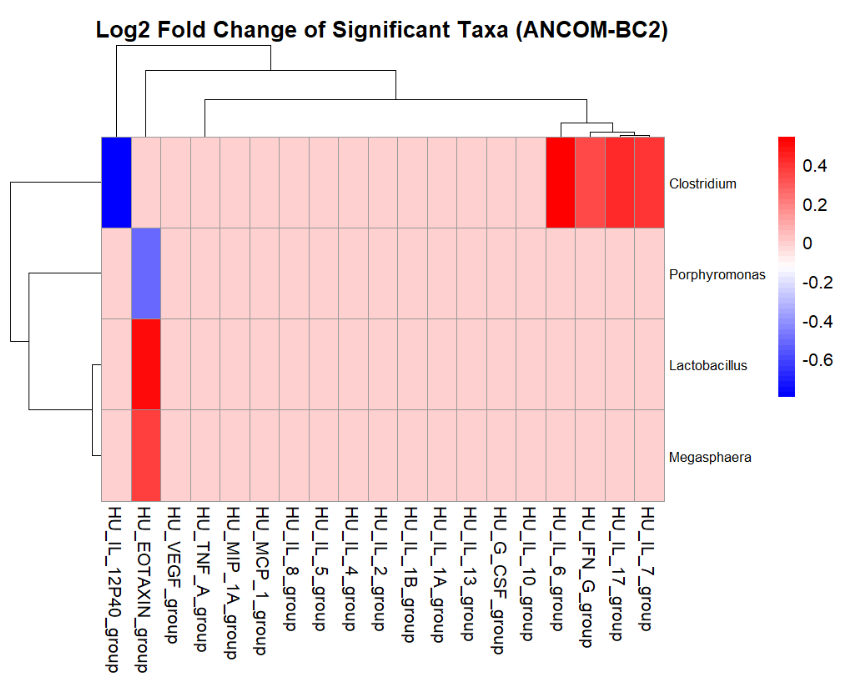

**Figure 9. ANCOM-BC Significant Cytokines and Microbial Taxa Log2 Fold Change**

To investigate microbial associations with cytokine levels, we categorized samples into “High” and “Low” groups for each cytokine based on the median cytokine concentration across all samples. The median thresholds used were: HU_EOTAXIN (168.17), HU_MCP_1 (126.92), HU_TNF_A (5.61), HU_IL_8 (2.85), HU_IL_1A (0.96), HU_IL_1B (1.01), and HU_IL_6 (2.73). Samples with cytokine levels above the median were classified as “High,” and those at or below the median as “Low.” These groupings allowed us to identify differentially abundant microbial taxa across high vs. low cytokine environments, focusing on cytokines previously correlated with alpha diversity (Shannon index).

The analysis (seen in Figure 9) revealed cytokine-specific associations with vaginal microbial composition. HU_EOTAXIN was associated with the largest number of significant taxa (3): Megasphaera, Lactobacillus, and Porphyromonas. Both Lactobacillus and Megasphaera exhibited positive log2 fold changes, indicating higher abundance in the low EOTAXIN group. In contrast, Porphyromonas had a negative log2FC, suggesting greater abundance under high EOTAXIN levels. These opposing trends may reflect differences in ecological niches or immune-related tolerances among taxa.

Interestingly, Clostridium was identified as the sole significantly associated taxon for five cytokines: HU_IL6, HU_IFN_G, HU_IL_17, HU_IL_7, and HU_IL_12P40. Of these, four cytokines (HU_IL6, HU_IFN_G, HU_IL_17, HU_IL_7) showed positive log2FC, indicating greater Clostridium abundance in low cytokine conditions. HU_IL_12P40 was the only cytokine where Clostridium was more abundant in the high cytokine group (negative log2FC). This pattern may suggest cytokine-specific immune regulation of Clostridial populations, potentially related to inflammation or microbial succession.

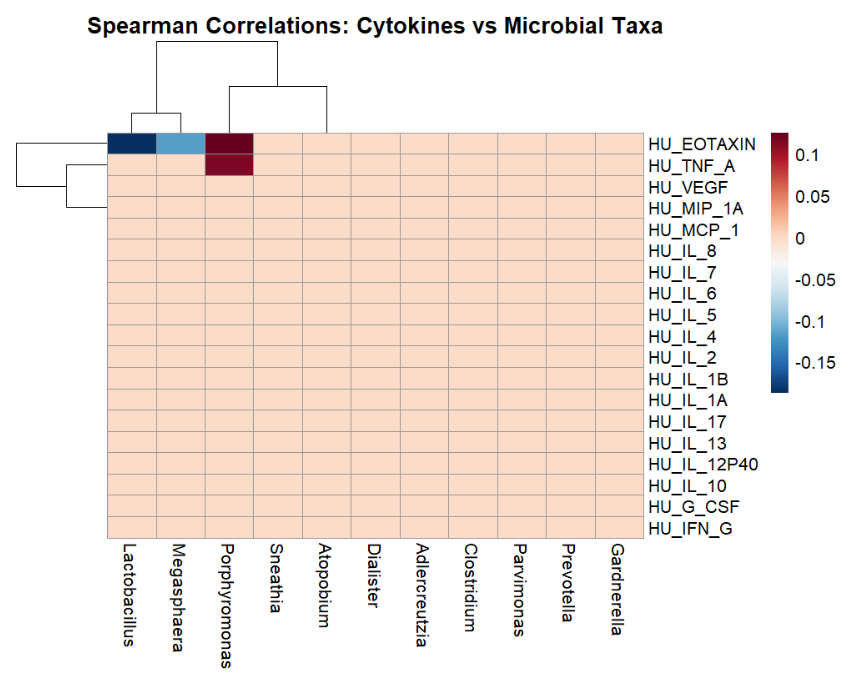

**Figure 10. Spearman Correlations for Cytokines and Microbial Taxa Heatmap**

In this Figure 10, several statistically significant but weak Spearman correlations were observed between specific cytokines and microbial taxa. HU_EOTAXIN showed a weak negative correlation with Lactobacillus (ρ = –0.188) and Megasphaera (ρ = –0.116), suggesting that higher levels of these bacteria are associated with lower circulating levels of EOTAXIN. These correlations are consistent with the ANCOM-BC2 results, which showed that both Lactobacillus and Megasphaera were significantly more abundant in the low EOTAXIN group (positive log2 fold change), further supporting a negative association between these taxa and EOTAXIN levels.

Conversely, Porphyromonas exhibited a weak positive correlation with HU_EOTAXIN (ρ = 0.125), indicating that increased Porphyromonas abundance is modestly associated with higher EOTAXIN concentrations. This pattern also aligns with the ANCOM-BC2 finding that Porphyromonas was significantly more abundant in the high EOTAXIN group (negative log2 fold change), reinforcing a positive relationship between Porphyromonas and inflammatory cytokine expression. Similarly, HU_TNF_A showed a weak positive correlation with Porphyromonas (ρ = 0.114), suggesting a comparable trend with this pro-inflammatory marker, although Porphyromonas was not identified as significant for TNF-α in ANCOM-BC2.

While these correlations are relatively weak in magnitude, their consistency with the direction of differential abundance observed in ANCOM-BC2 suggests potential microbial shifts associated with host inflammatory status.

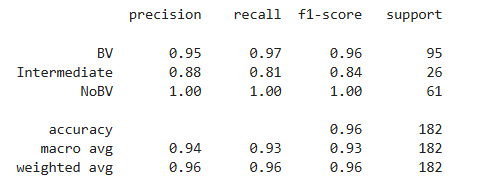

**Table 2. Random Forest Classification Results for Predicting Bacterial Vaginosis Using Microbial Taxa and Cytokines**

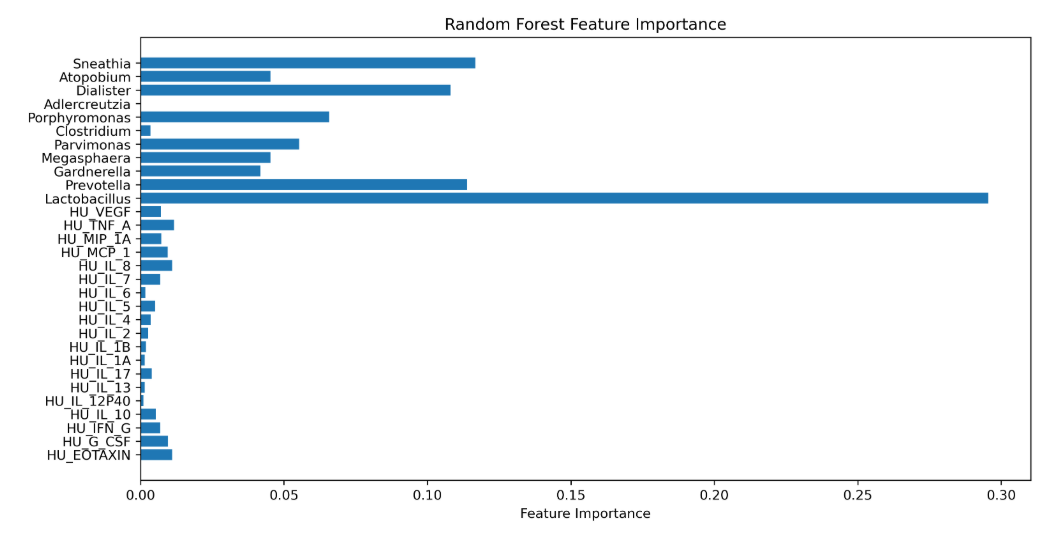

**Figure 11. Feature Importance for Predicting Bacterial Vaginosis Using Microbial Taxa and Cytokines**

The in Table 2 we see the results Random Forest model, trained using combined microbial taxa and cytokine features, achieved strong overall performance in classifying molecularBV status, with an accuracy of 96% on the test set. The model performed exceptionally well in identifying the NoBV class, achieving perfect precision, recall, and F1-score of 1.00, indicating flawless classification of NoBV samples. For the BV class, the model demonstrated high precision (0.95) and recall (0.97), effectively distinguishing BV cases while minimizing false positives. Performance for the Intermediate class was slightly lower, with precision of 0.88 and recall of 0.81, suggesting some misclassification within this group. The macro average F1-score of 0.93 reflects balanced predictive accuracy across all classes, while the weighted average F1-score of 0.96 highlights the model’s overall robustness considering class frequencies. These results show that integrating both vaginal microbiome composition and systemic cytokine measurements provides a powerful approach to accurately predict molecularBV status. Figure 11 shows that the model primarily relied on microbial taxa, particularly Lactobacillus, to predict BV status, indicating that microbial composition played a more significant role than cytokine levels in the model's classification.

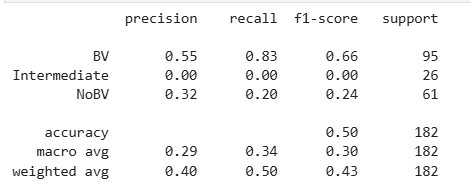

**Table 2. Random Forest Classification Results for Predicting Bacterial Vaginosis Using Just Cytokines**

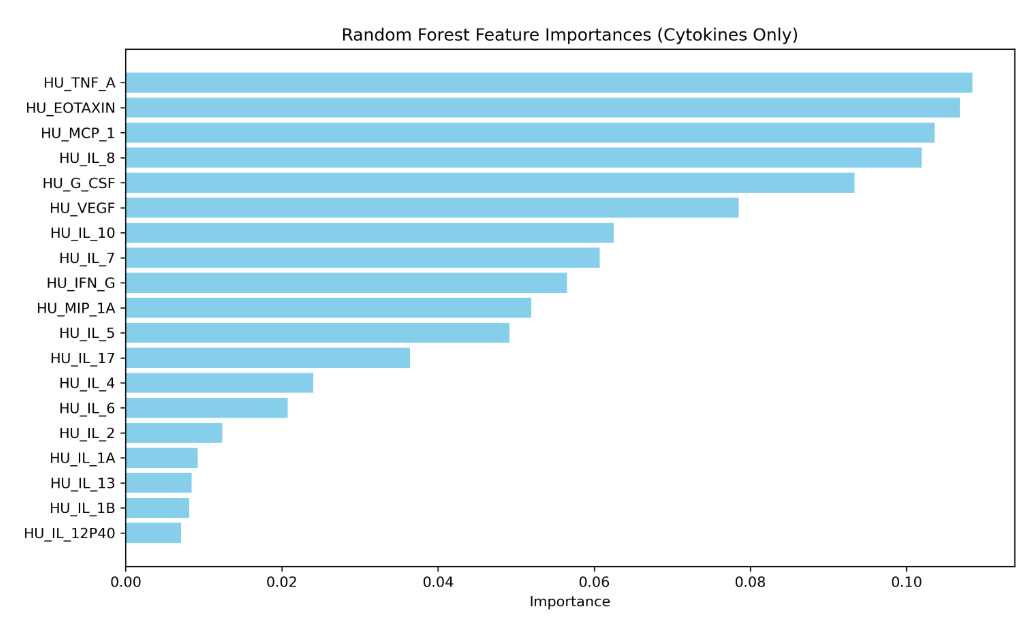

**Figure 12. Feature Importance for Predicting Bacterial Vaginosis Using Just Cytokines**

In Table 2 we can see when using only cytokine features to predict molecularBV status, the Random Forest model’s performance dropped considerably compared to the combined feature model. The overall accuracy was 50%, indicating the model correctly classified half of the test samples. The model showed reasonable recall for the BV class (0.83), meaning it identified most true BV cases; however, precision for this class was moderate (0.55), suggesting many false positives. Performance for the Intermediate and NoBV classes was poor, with precision and recall near zero for Intermediate, indicating the model failed to identify this group accurately. The NoBV class also showed low precision (0.32) and recall (0.20), reflecting difficulty in correctly classifying samples from this category. The confusion matrix highlights substantial misclassification, particularly with many NoBV samples incorrectly labeled as BV and Intermediate samples not being identified correctly. These results suggest that cytokine data alone provide limited discriminatory power for molecularBV status, especially for the Intermediate and NoBV classes.

From Figure 12 we can see that HU Eotaxin is the top predictors of bacterial vaginosis.  HU_EOTAXIN demonstrated the strongest positive correlation with Shannon diversity (alpha diversity), as shown in the Spearman correlation analysis, and this was visually supported by both scatter and box plots. In the PERMANOVA results, HU_EOTAXIN was also significantly associated with differences in microbial composition, suggesting that its levels may reflect broader shifts in the microbiome. Differential abundance testing (ANCOM-BC2) further confirmed distinct microbial associations with EOTAXIN levels, identifying three significantly altered taxa, Lactobacillus, Megasphaera, and Porphyromonas, with directionality in their abundance depending on cytokine levels. Finally, weak but consistent negative correlations between HU_EOTAXIN and Lactobacillus/Megasphaera, along with a positive correlation with Porphyromonas, reinforce its role in shaping or responding to microbiome dynamics. The fact that HU_EOTAXIN is not only statistically significant in univariate analyses but also holds substantial predictive weight in a multivariate machine learning model highlights its potential as a biomarker linking host immune signaling and microbial states.

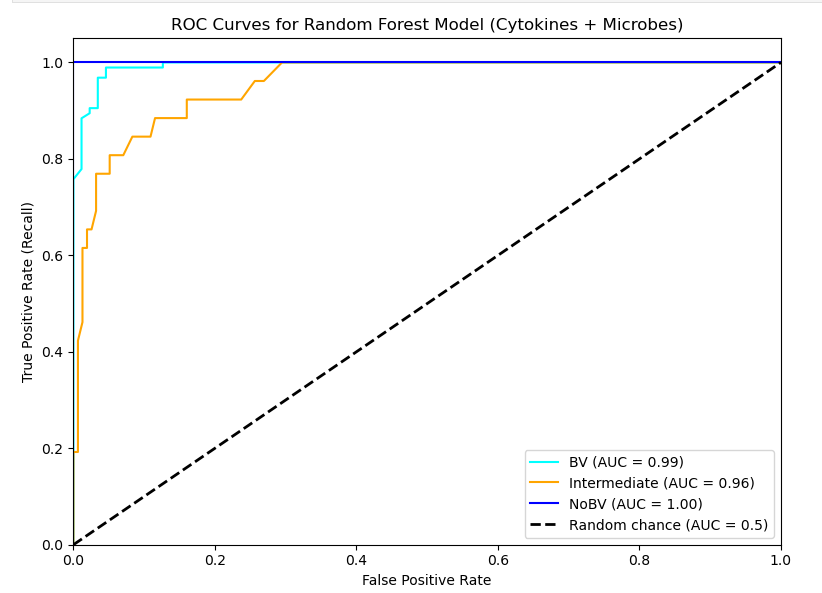

**Figure 13. Multi Class ROC Curves for Random Forest Model (Cytokines + Microbes)**)

To assess the discriminative performance of the random forest classifier trained on cytokine data alone, we computed one-vs-rest receiver operating characteristic (ROC) curves and corresponding area under the curve (AUC) values for each bacterial vaginosis (BV) status group: BV, Intermediate, and No BV. We can see in Figure 13 that the model achieved excellent classification performance, with AUC scores of 0.99 for BV, 0.96 for Intermediate, and 1.00 for No BV. These values substantially exceed the baseline of random chance (AUC = 0.5), indicating strong predictive power. Notably, the perfect separation of No BV samples and near-perfect classification of BV samples highlight the model's robustness. The slightly lower AUC for the Intermediate class likely reflects the clinical and biological ambiguity associated with this transitional state.


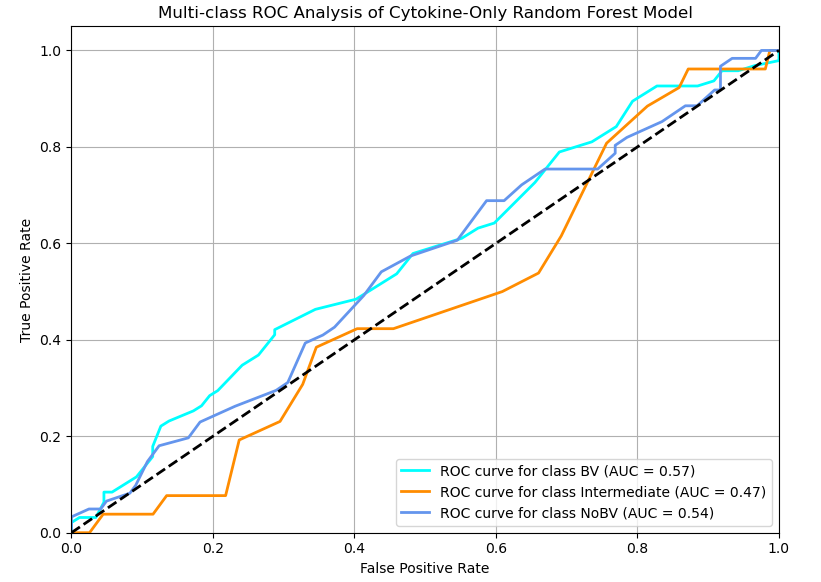

**Figure 14. Multi Class ROC Curves for Cytokine only Random Forest Model**

To evaluate the ability of cytokine profiles to discriminate bacterial vaginosis (BV) status, a Random Forest classifier was trained using cytokine features alone. As shown in Figure 14, the resulting ROC curves reveal limited discriminatory power across all classes. The Area Under the Curve (AUC) scores were 0.57 for BV, 0.47 for Intermediate, and 0.54 for NoBV. These values are close to the AUC of 0.5 expected from random chance, indicated by the diagonal reference line. While the model shows marginally better-than-random performance for BV and NoBV classifications, it performs slightly worse than random for the Intermediate class.

This suggests that cytokine features alone are insufficient for reliable classification of BV status. The minimal separation from the random classifier baseline indicates limited predictive utility in their current form. Further model optimization such as enhanced feature selection, correction for class imbalance, or algorithmic tuning may be necessary to improve performance and support potential clinical application.

### Discussion

This study investigated whether vaginal microbiome composition is reflected in systemic immune signaling, focusing on associations between blood-derived cytokine levels and vaginal microbial features. We explored how immune biomarkers relate to microbial diversity and composition, as well as bacterial vaginosis (BV) status. The primary aim was to determine whether systemic cytokines capture biologically meaningful variation in the vaginal microbiome, suggesting a broader immunological impact. We also evaluated the predictive utility of cytokine and microbial features using machine learning to assess their joint capacity to classify BV status.

Consistent with prior research, BV-positive samples exhibited significantly higher microbial alpha diversity (Shannon index) compared to healthy (NoBV) samples, reflecting the characteristic dysbiosis of BV. The Intermediate group demonstrated a broad diversity range, likely representing transitional or heterogeneous microbial states. In contrast, HPV infection status showed no significant correlation with microbiome diversity, suggesting its influence on the vaginal microbiome may be limited or secondary to other factors such as host immune responses.

Analyses revealed modest but consistent positive correlations between several pro-inflammatory cytokines, including HU_EOTAXIN, HU_MCP_1, and HU_TNF_A, and microbial diversity. Among these, HU_EOTAXIN emerged as the most robust and biologically meaningful marker, consistently demonstrating strong associations with alpha diversity, microbial community composition, and differentially abundant taxa (notably Lactobacillus, Megasphaera, and Porphyromonas). Beta diversity analyses (PCoA and PERMANOVA) confirmed that variations in EOTAXIN and TNF-α levels were significantly linked to microbial community shifts, albeit with small effect sizes, suggesting subtle but real immune–microbiome interactions. Differential abundance results further showed that elevated EOTAXIN levels coincide with depletion of beneficial taxa such as Lactobacillus and enrichment of potential pathobionts like Porphyromonas, supporting a model in which heightened inflammatory signaling reflects or contributes to microbial dysbiosis.

Machine learning models provided additional insight into the predictive utility of these features. A Random Forest classifier trained on combined cytokine and microbial data demonstrated strong performance, achieving high accuracy in classifying molecular BV status. One-vs-rest ROC analysis revealed excellent discriminative ability, with AUC scores of 0.99 for BV, 0.96 for Intermediate, and 1.00 for NoBV. These values indicate near-perfect classification of BV and NoBV groups and highlight the potential of integrated host–microbiome data to enhance diagnostic accuracy. The slightly lower performance for the Intermediate group likely reflects its clinical and biological ambiguity, consistent with its transitional microbiome profile.

In contrast, a model trained on cytokine features alone showed limited predictive power. ROC curves for the cytokine-only classifier were near the random baseline (AUC = 0.5), with class-specific AUC scores of 0.57 for BV, 0.47 for Intermediate, and 0.54 for NoBV. These results suggest that systemic cytokines, in isolation, are insufficient for reliable classification of BV status. The minimal separation from the random classifier line underscores the limitations of immune biomarkers alone and emphasizes the importance of microbial features for meaningful predictive performance.

Collectively, these findings provide preliminary evidence that vaginal microbial states are reflected in systemic cytokine signals, supporting the hypothesis that the vaginal microbiome can influence host immune status beyond the local mucosal environment. While systemic cytokines, particularly EOTAXIN, show clear associations with microbial diversity and composition, they appear insufficient for standalone classification of BV. However, their integration with microbiome data significantly improves diagnostic accuracy. These exploratory results suggest the potential of systemic cytokines as biomarkers of vaginal dysbiosis and lay the groundwork for future studies to validate these associations in larger cohorts and to investigate causal mechanisms.

### Conclusion

Our integrative analysis reveals a complex interplay between host cytokine responses and the vaginal microbiome in relation to bacterial vaginosis (BV). While microbial taxa, particularly Lactobacillus, remain the most robust predictors of molecular BV status, cytokines such as HU_EOTAXIN provide valuable complementary insight into microbial community shifts and diversity. The consistent identification of EOTAXIN as a key immunological marker across correlation, differential abundance, and machine learning analyses underscores its potential role in linking host immune signaling with vaginal microbial ecology.

Despite these advances, the cytokine-only model demonstrated poor classification performance, with ROC AUC values near random chance across all classes. This finding highlights the limited discriminatory power of systemic cytokines in isolation and emphasizes the complexity of BV pathogenesis, which likely requires integration of diverse biological data for accurate classification.

This study faces several limitations. Sample size imbalances across BV categories( BV (n = 475), NoBV (n = 306), and Intermediate (n = 129)) may reduce statistical power and limit generalizability, particularly for the Intermediate group. Additionally, the modest effect sizes observed for cytokine associations suggest that immune factors interact with other unmeasured host, microbial, or environmental variables. Potential confounders such as sexual behavior, hormonal status, and other clinical factors were not accounted for and may have influenced the observed associations. These constraints likely contributed to challenges in improving model performance and detecting more subtle biological effects.

Future research should focus on expanding cohort sizes with more balanced group representation and incorporating longitudinal sampling to clarify the temporal relationships between cytokine shifts and microbiome changes. Broadening the  cytokine panel and including additional host factors could enhance predictive models and yield more personalized insights into vaginal health. Advances in machine learning, including improved feature selection, class balancing, and alternative algorithmic approaches, may further refine classification accuracy and clinical utility.

In summary, our findings deepen the understanding of interactions between vaginal microbial diversity, systemic immune signaling, and BV status. While microbial composition remains the dominant determinant of BV classification, the incorporation of systemic cytokine measures, particularly HU_EOTAXIN, offers promising avenues to enhance diagnostic and prognostic capabilities in reproductive health.



### References: 

Baker, Rosalyn et al. “Increased plasma levels of adipokines and inflammatory markers in older women with persistent HPV infection.” Cytokine vol. 53,3 (2011): 282-5. doi:10.1016/j.cyto.2010.11.014

Li, Bohan et al. “The value of cytokine levels in triage and risk prediction for women with persistent high-risk human papilloma virus infection of the cervix.” Infectious agents and cancer vol. 14 16. 28 Jun. 2019, doi:10.1186/s13027-019-0231-z

Mbulaiteye, S M et al. “Plasma cytokine levels and human papillomavirus infection at the cervix in rural Nigerian women.” Cytokine vol. 64,1 (2013): 146-51. doi:10.1016/j.cyto.2013.07.028

Moscicki, Anna-Barbara et al. “Cervical-Vaginal Microbiome and Associated Cytokine Profiles in a Prospective Study of HPV 16 Acquisition, Persistence, and Clearance.” Frontiers in cellular and infection microbiology vol. 10 569022. 25 Sep. 2020, doi:10.3389/fcimb.2020.569022

Musa, Jonah et al. “Vaginal microbiome community state types and high-risk human papillomaviruses in cervical precancer and cancer in North-central Nigeria.” BMC cancer vol. 23,1 683. 20 Jul. 2023, doi:10.1186/s12885-023-11187-5

Ntuli, Lungelo et al. “Role of Immunity and Vaginal Microbiome in Clearance and Persistence of Human Papillomavirus Infection.” Frontiers in cellular and infection microbiology vol. 12 927131. 7 Jul. 2022, doi:10.3389/fcimb.2022.927131

Sharifian, K., Shoja, Z. & Jalilvand, S. The interplay between human papillomavirus and vaginal microbiota in cervical cancer development. Virol J 20, 73 (2023). https://doi.org/10.1186/s12985-023-02037-8

Usyk, Mykhaylo et al. “Cervicovaginal Microbiome and Natural History of Chlamydia Trachomatis in Adolescents and Young Women: Cell.” Cell, 20 Feb. 2025, www.cell.com/cell/fulltext/S0092-8674(24)01424-7. 

Usyk, M., Schlecht, N.F., Pickering, S. et al. molBV reveals immune landscape of bacterial vaginosis and predicts human papillomavirus infection natural history. Nat Commun 13, 233 (2022). https://doi.org/10.1038/s41467-021-27628-3

Zhou, Zi-Wei et al. “From Microbiome to Inflammation: The Key Drivers of Cervical Cancer.” Frontiers in microbiology vol. 12 767931. 15 Nov. 2021, doi:10.3389/fmicb.2021.767931